In [1]:
import zstandard as zstd
import jsonlines
import chess.gaviota
import chess.engine
import chess 
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def count_pieces(fen):
    return sum(fen_piece.isalpha() for fen_piece in fen.split()[0])


def process_json_object(obj):
    fen = obj['fen']
    piece_count = count_pieces(fen)
    return 0 <= piece_count <= 10

def extract_fen_and_cp(data):
    fen = data.get('fen')
    first_eval = data.get('evals')[0] if data.get('evals') else None
    first_cp = first_eval.get('pvs')[0].get('cp') if first_eval and first_eval.get('pvs') else None
    return fen, first_cp

def process_file(file_path):
    result = {}
    with jsonlines.open(file_path) as reader:
        for data in reader:
            if process_json_object(data):
                fen, first_cp = extract_fen_and_cp(data)
                if fen is not None and first_cp is not None:
                    fen_split = fen.split()[0]
                    if all(char != 'Q' and char != 'q' for char in fen_split):
                        if (-400 <= first_cp <= -150) or (150 <= first_cp <= 400):
                            result[fen] = first_cp
    return result

In [3]:
position_eval1=process_file('cleaned_lichess_db_eval.jsonl1')
position_eval2=process_file('cleaned_lichess_db_eval.jsonl2')
position_eval3=process_file('cleaned_lichess_db_eval.jsonl3')
position_eval4=process_file('cleaned_lichess_db_eval.jsonl4')
position_eval5=process_file('cleaned_lichess_db_eval.jsonl5')


In [4]:
combined_endgames=position_eval1.copy()
combined_endgames.update(position_eval2)
combined_endgames.update(position_eval3)
combined_endgames.update(position_eval4)
combined_endgames.update(position_eval5)
material_df = pd.DataFrame(list(combined_endgames.items()), columns=['FEN', 'Evaluation'])
material_df['Evaluation'] = material_df['Evaluation'] / 100


In [5]:
material_df.head()

,FEN,Evaluation
0,R4k2/5br1/3N4/p3P3/8/5K2/8/8 b - -,3.91
1,1nb5/1p6/1kp5/8/8/6B1/8/3R3K w - -,2.25
2,8/8/4kpp1/3p1b2/p6P/2B5/6P1/6K1 b - -,-2.47
3,8/8/8/3N4/2KB4/5k2/8/8 b - -,2.45
4,8/8/3N1N1k/5K2/6p1/8/8/8 w - -,3.24


In [6]:
def fen_to_matrix(fen):
    matrix_position = np.full((8, 8), '0', dtype=str) 
    piece_placement = fen.split()[0]  
    ranks = piece_placement.split('/')  
    
    for i, rank in enumerate(ranks):
        j = 0
        for char in rank:
            if char.isdigit():
                j += int(char) 
            else:
                matrix_position[i, j] = char  
                j += 1
    
    return matrix_position


material_df['Position'] = material_df['FEN'].apply(fen_to_matrix)

In [7]:
def material_count(fen):

    piece_values_white = {
        'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9 }
    
    piece_values_black = {'p': 1, 'n': 3, 'b': 3, 'r': 5, 'q': 9 }
    
    piece_placement = fen.split()[0]
    
    material_white = 0
    material_black = 0
    material_diff= 0 
    
    for char in piece_placement:
        if char in piece_values_white:
            material_white += piece_values_white[char]
        elif char in piece_values_black:
            material_black += piece_values_black[char]
        
    material_diff=material_white-material_black    
    
    
    return material_white, material_black, material_diff

material_df[['Material White', 'Material Black', 'Material Diff']] = material_df['FEN'].apply(lambda fen: pd.Series(material_count(fen)))

In [8]:
def count_pieces_w(chess_position):
    piece_counts = {
        'pawns': 0,
        'knights': 0,
        'bishops': 0,
        'rooks': 0
    }
    
    for row in chess_position:
        for piece in row:
            if piece == 'P':
                piece_counts['pawns'] += 1
            elif piece == 'N':
                piece_counts['knights'] += 1
            elif piece == 'B':
                piece_counts['bishops'] += 1
            elif piece == 'R':
                piece_counts['rooks'] += 1
    
    return piece_counts
material_df[['White Pawns', 'White Knights', 'White Bishops', 'White Rooks']] = material_df['Position'].apply(lambda x: pd.Series(count_pieces_w(x)))

In [9]:
def count_pieces_b(chess_position):
    piece_counts_b = {
        'pawns': 0,
        'knights': 0,
        'bishops': 0,
        'rooks': 0
    }
    
    for row in chess_position:
        for piece in row:
            if piece == 'p':
                piece_counts_b['pawns'] += 1
            elif piece == 'n':
                piece_counts_b['knights'] += 1
            elif piece == 'b':
                piece_counts_b['bishops'] += 1
            elif piece == 'r':
                piece_counts_b['rooks'] += 1
    
    return piece_counts_b
material_df[['Black Pawns', 'Black Knights', 'Black Bishops', 'Black Rooks']] = material_df['Position'].apply(lambda x: pd.Series(count_pieces_b(x)))

In [10]:
def player_turn(fen):
    fen_parts = fen.split()
    active_color = fen_parts[1]
    return 1 if active_color == 'w' else 0

material_df['Player Turn'] = material_df['FEN'].apply(player_turn)

In [11]:
def count_passed_pawns_w(position):
    passed_pawns = 0
    for rank_index in [3, 2, 1]:  
        rank = position[rank_index]
        
        for file_index, piece in enumerate(rank):
            if piece == 'P':  
                is_passed = True
                if position[rank_index - 1][file_index] == 'p':
                    is_passed = False
                else:
                    if file_index > 0 and position[rank_index - 1][file_index - 1] == 'p':
                        is_passed = False
                    elif file_index < 7 and position[rank_index - 1][file_index + 1] == 'p':
                        is_passed = False
                
                if is_passed:
                    passed_pawns += 1
    
    return passed_pawns
material_df['Passed Pawns White'] = material_df['Position'].apply(count_passed_pawns_w)

In [12]:
def count_passed_pawns_b(position):
    passed_pawns = 0
    for rank_index in [4, 5, 6]: 
        rank = position[rank_index]
        
        for file_index, piece in enumerate(rank):
            if piece == 'p': 
                is_passed = True
                if position[rank_index + 1][file_index] == 'P':
                    is_passed = False
                else:
                    if file_index > 0 and position[rank_index + 1][file_index - 1] == 'P':
                        is_passed = False
                    elif file_index < 7 and position[rank_index + 1][file_index + 1] == 'P':
                        is_passed = False
                
                if is_passed:
                    passed_pawns += 1
    
    return passed_pawns
material_df['Passed Pawns Black'] = material_df['Position'].apply(count_passed_pawns_b)

In [13]:
def min_distance_from_center_w(board):
    
    central_squares = [(3, 3), (3, 4), (4, 3), (4, 4)]
    
    
    king_pos = None
    for row in range(8):
        for col in range(8):
            if board[row][col] == 'K':
                king_pos = (row, col)
                break
        if king_pos:
            break
    
   
    if not king_pos:
        return None
    
    
    def chebyshev_distance(pos1, pos2):
        return max(abs(pos1[0] - pos2[0]), abs(pos1[1] - pos2[1]))
    
    
    distances = [chebyshev_distance(king_pos, center) for center in central_squares]
    
    
    return min(distances)

material_df['King Distance to Centre White'] = material_df['Position'].apply(min_distance_from_center_w)

In [14]:
def min_distance_from_center_b(board):
    
    central_squares = [(3, 3), (3, 4), (4, 3), (4, 4)]
    
   
    king_pos = None
    for row in range(8):
        for col in range(8):
            if board[row][col] == 'k':
                king_pos = (row, col)
                break
        if king_pos:
            break
    
    
    if not king_pos:
        return None
    
   
    def chebyshev_distance(pos1, pos2):
        return max(abs(pos1[0] - pos2[0]), abs(pos1[1] - pos2[1]))
    
    
    distances = [chebyshev_distance(king_pos, center) for center in central_squares]
    
    
    return (min(distances))

material_df['King Distance to Centre Black'] = material_df['Position'].apply(min_distance_from_center_b)

In [15]:
material_df.tail(55000)

,FEN,Evaluation,Position,Material White,Material Black,Material Diff,White Pawns,White Knights,White Bishops,White Rooks,Black Pawns,Black Knights,Black Bishops,Black Rooks,Player Turn,Passed Pawns White,Passed Pawns Black,King Distance to Centre White,King Distance to Centre Black
19490,2k5/8/r5pp/P7/6P1/6K1/5P2/R7 w - -,2.00,"[[0, 0, k, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",8,7,1,3,0,0,1,2,0,0,1,1,1,0,2,3
19491,8/2P5/1n6/1Nk2b2/8/1K6/8/8 b - -,-2.22,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, P, 0, 0, 0, ...",4,6,-2,1,1,0,0,0,1,1,0,0,1,0,2,1
19492,8/8/4k3/8/3K4/5B2/6N1/8 b - -,1.98,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",6,0,6,0,1,1,0,0,0,0,0,0,0,0,0,1
19493,8/8/8/3K1k2/8/5B2/6N1/8 b - -,1.91,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",6,0,6,0,1,1,0,0,0,0,0,0,0,0,0,1
19494,8/1Nk5/K3B3/8/8/8/8/8 w - -,1.83,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, N, k, 0, 0, 0, ...",6,0,6,0,1,1,0,0,0,0,0,1,0,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74485,8/8/8/8/1R4p1/3k4/r4PK1/8 b - -,3.35,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",6,6,0,1,0,0,1,1,0,0,1,0,0,1,2,1
74486,3R2K1/8/1p2k3/p6r/P7/8/8/5B2 w - -,3.50,"[[0, 0, 0, R, 0, 0, K, 0], [0, 0, 0, 0, 0, 0, ...",9,7,2,1,0,1,1,2,0,0,1,1,0,0,3,1
74487,8/5k1B/8/6K1/6N1/8/8/8 w - -,2.02,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, k, ...",6,0,6,0,1,1,0,0,0,0,0,1,0,0,2,2
74488,8/6k1/4BN2/8/3K4/8/8/8 w - -,2.13,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",6,0,6,0,1,1,0,0,0,0,0,1,0,0,0,2


In [16]:

knight_bishop_vs_rook = material_df[
    (((material_df['White Knights'] == 1) & (material_df['White Bishops'] == 1) & (material_df['White Rooks'] == 0)) &
     ((material_df['Black Knights'] == 0) & (material_df['Black Bishops'] == 0) & (material_df['Black Rooks'] == 1)))|
    (((material_df['White Knights'] == 0) & (material_df['White Bishops'] == 0) & (material_df['White Rooks'] == 1)) &
     ((material_df['Black Knights'] == 1) & (material_df['Black Bishops'] == 1) & (material_df['Black Rooks'] == 0))) &
    (material_df['Material Diff']==0)
]


knight_vs_bishop = material_df[
    ((material_df['White Knights'] == 1) & (material_df['White Bishops'] == 0) & (material_df['White Rooks'] == 0) & 
     (material_df['Black Knights'] == 0) & (material_df['Black Bishops'] == 1) & (material_df['Black Rooks'] == 0)) |
    ((material_df['White Knights'] == 0) & (material_df['White Bishops'] == 1) & (material_df['White Rooks'] == 0) & 
     (material_df['Black Knights'] == 1) & (material_df['Black Bishops'] == 0) & (material_df['Black Rooks'] == 0)) &
    (material_df['Material Diff']==0) ]


Percentage of games won by the knight: 41.33%
Percentage of games won by the bishop: 58.67%


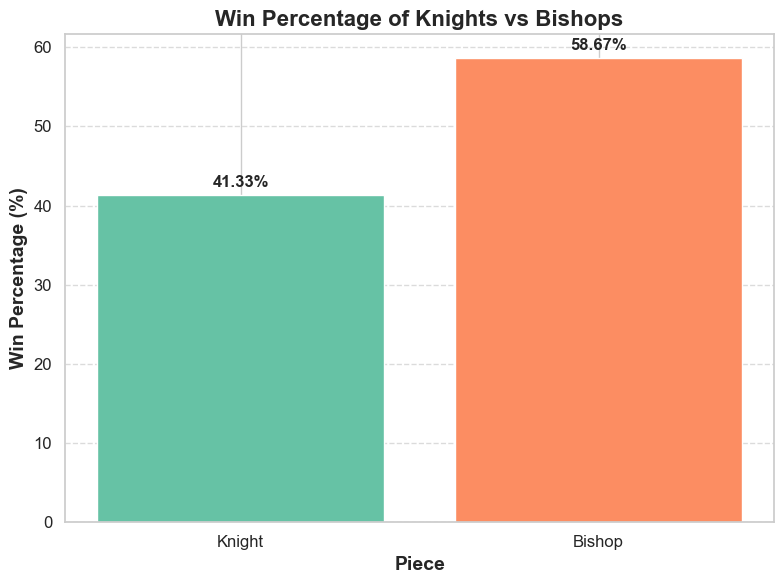

In [17]:
knight_vs_bishop = knight_vs_bishop[
    ((knight_vs_bishop['White Knights'] == 1) & (knight_vs_bishop['White Bishops'] == 0) & (knight_vs_bishop['Black Knights'] == 0) & (knight_vs_bishop['Black Bishops'] == 1)) |
    ((knight_vs_bishop['White Knights'] == 0) & (knight_vs_bishop['White Bishops'] == 1) & (knight_vs_bishop['Black Knights'] == 1) & (knight_vs_bishop['Black Bishops'] == 0))
]


def determine_winner(row):
    if row['Evaluation'] > 0:
        return 'White'
    elif row['Evaluation'] < 0:
        return 'Black'
    else:
        return 'Draw'


knight_vs_bishop['Winner'] = knight_vs_bishop.apply(determine_winner, axis=1)


knight_wins = knight_vs_bishop[
    ((knight_vs_bishop['White Knights'] == 1) & (knight_vs_bishop['Winner'] == 'White')) |
    ((knight_vs_bishop['Black Knights'] == 1) & (knight_vs_bishop['Winner'] == 'Black'))
].shape[0]

bishop_wins = knight_vs_bishop[
    ((knight_vs_bishop['White Bishops'] == 1) & (knight_vs_bishop['Winner'] == 'White')) |
    ((knight_vs_bishop['Black Bishops'] == 1) & (knight_vs_bishop['Winner'] == 'Black'))
].shape[0]

total_games = knight_vs_bishop.shape[0]

knight_win_percentage = (knight_wins / total_games) * 100
bishop_win_percentage = (bishop_wins / total_games) * 100

print(f"Percentage of games won by the knight: {knight_win_percentage:.2f}%")
print(f"Percentage of games won by the bishop: {bishop_win_percentage:.2f}%")
pieces = ['Knight', 'Bishop']
win_percentages = [knight_win_percentage, bishop_win_percentage]


import seaborn as sns


sns.set(style="whitegrid")
palette = sns.color_palette("Set2")


plt.figure(figsize=(8, 6))
plt.bar(pieces, win_percentages, color=palette)


for i, percentage in enumerate(win_percentages):
    plt.text(i, percentage + 1, f'{percentage:.2f}%', ha='center', fontsize=12, fontweight='bold')


plt.xlabel('Piece', fontsize=14, fontweight='bold')
plt.ylabel('Win Percentage (%)', fontsize=14, fontweight='bold')


plt.title('Win Percentage of Knights vs Bishops', fontsize=16, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()




C:\Users\David\AppData\Local\Temp\ipykernel_59688\3345798753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knight_bishop_vs_rook['Winner'] = knight_bishop_vs_rook.apply(determine_winner, axis=1)


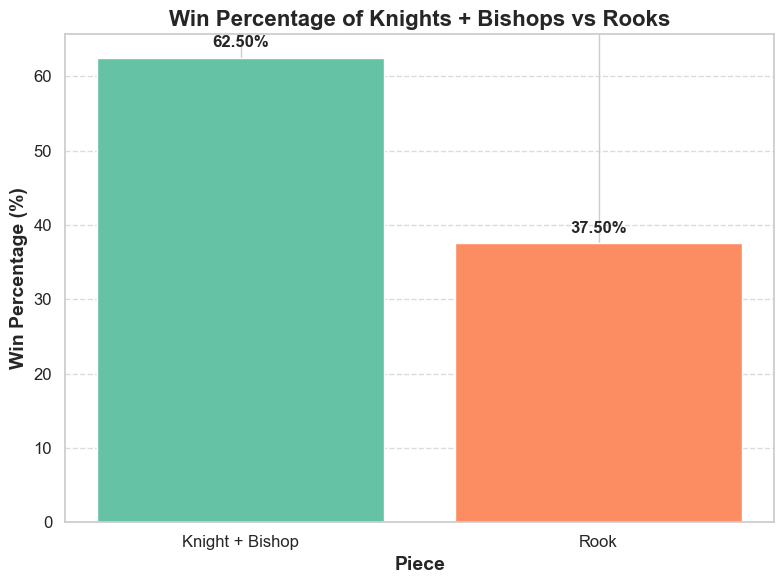

In [18]:
knight_bishop_vs_rook['Winner'] = knight_bishop_vs_rook.apply(determine_winner, axis=1)

knight_bishop__wins = knight_bishop_vs_rook[
    ((knight_bishop_vs_rook['White Knights'] == 1) & (knight_bishop_vs_rook['Winner'] == 'White')) |
    ((knight_bishop_vs_rook['Black Knights'] == 1) & (knight_bishop_vs_rook['Winner'] == 'Black'))
].shape[0]



rook_wins = knight_bishop_vs_rook[
    ((knight_bishop_vs_rook['White Rooks'] == 1) & (knight_bishop_vs_rook['Winner'] == 'White')) |
    ((knight_bishop_vs_rook['Black Rooks'] == 1) & (knight_bishop_vs_rook['Winner'] == 'Black'))
].shape[0]

total_games1 = knight_bishop_vs_rook.shape[0]

knight_bishop_win_percentage = (knight_bishop__wins / total_games1) * 100
rook_win_percentage = (rook_wins / total_games1) * 100

win_percentages1 = [knight_bishop_win_percentage, rook_win_percentage]
pieces = ['Knight + Bishop', 'Rook']


sns.set(style="whitegrid")
palette = sns.color_palette("Set2")


plt.figure(figsize=(8, 6))
bars = plt.bar(pieces, win_percentages1, color=palette)


for bar, percentage in zip(bars, win_percentages1):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{percentage:.2f}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel('Piece', fontsize=14, fontweight='bold')
plt.ylabel('Win Percentage (%)', fontsize=14, fontweight='bold')


plt.title('Win Percentage of Knights + Bishops vs Rooks', fontsize=16, fontweight='bold')


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

In [19]:
fen =  material_df['FEN'].values.reshape(-1, 1)
evaluations = material_df['Evaluation'].values.reshape(-1, 1)
material_differences = material_df['Material Diff'].values.reshape(-1, 1)
player_turn=material_df['Player Turn'].values.reshape(-1,1)
passed_pawn_w=material_df['Passed Pawns White'].values.reshape(-1,1)
passed_pawn_b=material_df['Passed Pawns Black'].values.reshape(-1,1)
king_active_w=material_df['King Distance to Centre White'].values.reshape(-1,1)
king_active_b=material_df['King Distance to Centre Black'].values.reshape(-1,1)
material_white = material_df['Material White'].values.reshape(-1, 1)
material_black = material_df['Material Black'].values.reshape(-1, 1)

In [20]:
white_pawns=material_df['White Pawns'].values.reshape(-1,1)
black_pawns=material_df['Black Pawns'].values.reshape(-1,1)
white_knights=material_df['White Knights'].values.reshape(-1,1)
black_knights=material_df['Black Knights'].values.reshape(-1,1)
white_bishops=material_df['White Bishops'].values.reshape(-1,1)
black_bishops=material_df['Black Bishops'].values.reshape(-1,1)
white_rooks=material_df['White Rooks'].values.reshape(-1,1)
black_rooks=material_df['Black Rooks'].values.reshape(-1,1)

In [21]:
def standardise(data_matrix):
    row_of_means = np.mean(data_matrix, axis=0)
    standardised_matrix = data_matrix - row_of_means
    row_of_stds = np.std(standardised_matrix, axis=0)
    return (standardised_matrix / row_of_stds), row_of_means, row_of_stds
def de_standardise(standardised_matrix, row_of_means, row_of_stds):
    matrix = np.copy(standardised_matrix * row_of_stds)
    return matrix + row_of_means

In [22]:
chess_input = np.c_[material_white,material_black,passed_pawn_w,passed_pawn_b,king_active_w,king_active_b,player_turn]
chess_labels = evaluations.reshape(-1, 1)
chess_input, chess_row_of_means, chess_row_of_stds = standardise(chess_input)
parameter_names = ["Material Points White", "Material Points Black", "White Passed Pawns", "Black Passed Pawns", "King Activity White", "King Activity Black","Player Turn"]

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

model = RandomForestRegressor()
model.fit(chess_input, chess_labels.ravel()) 


importances = model.feature_importances_
importances=[f"{np.round(i * 100, 2)}%" for i in importances]
importance_df = pd.DataFrame({
    "Parameter Name": parameter_names,
    "Importance": importances
})


print(importance_df)

          Parameter Name Importance
0  Material Points White     40.92%
1  Material Points Black     35.89%
2     White Passed Pawns      5.36%
3     Black Passed Pawns      5.57%
4    King Activity White       4.9%
5    King Activity Black      5.34%
6            Player Turn      2.02%


In [24]:
pieces_input= np.c_[white_pawns,black_pawns,white_knights,black_knights,white_bishops,black_bishops,white_rooks,black_rooks]
pieces_input, pieces_row_of_means, pieces_row_of_stds = standardise(pieces_input)

In [25]:
model_pieces = RandomForestRegressor()
model_pieces.fit(pieces_input, chess_labels.ravel()) 


importances_pieces = model_pieces.feature_importances_
pieces_names=['White Pawns','Black Pawns','White Knights','Black Knights','White Bishops','Black Bishops','White Rooks','Black Rooks']
importances_pieces=[f"{np.round(i * 100, 2)}%" for i in importances_pieces]
importance_pieces_df = pd.DataFrame({
    "Piece": pieces_names,
    "Importance": importances_pieces
})


print(importance_pieces_df)

           Piece Importance
0    White Pawns     14.03%
1    Black Pawns     15.57%
2  White Knights     10.99%
3  Black Knights      8.47%
4  White Bishops     11.61%
5  Black Bishops     11.13%
6    White Rooks     13.77%
7    Black Rooks     14.43%


In [26]:
np.random.seed(42)
indices = np.arange(chess_input.shape[0])
np.random.shuffle(indices)
split_point = int(0.8 * chess_input.shape[0])
X_train, X_val = chess_input[indices[:split_point]], chess_input[indices[split_point:]]
y_train, y_val = chess_labels[indices[:split_point]], chess_labels[indices[split_point:]]
validation_fens = fen[indices[split_point:]]

In [27]:
def linear_regression_data(data_input):
    first_column = np.ones((len(data_input), 1))
    X_matrix = np.c_[data_input]
    return X_matrix

def linear_regression(data_matrix, data_outputs):
    a=data_matrix.T@data_matrix
    b=data_matrix.T@data_outputs
    return np.linalg.solve(a, b)

def model_function(data_matrix, weights):
    return data_matrix @ weights

In [28]:
chess_data_matrix = linear_regression_data(X_train)
chess_weights=linear_regression(chess_data_matrix, y_train)
chess_weights

array([[ 1.4947918 ],
       [-1.73405914],
       [ 0.50791983],
       [-0.15335824],
       [ 0.01626629],
       [ 0.1329867 ],
       [ 0.10507689]])

In [29]:

chess_weights = chess_weights.flatten()


weights_df = pd.DataFrame({
    "Parameter Name": parameter_names,
    "Weight": chess_weights
})


print(weights_df)

          Parameter Name    Weight
0  Material Points White  1.494792
1  Material Points Black -1.734059
2     White Passed Pawns  0.507920
3     Black Passed Pawns -0.153358
4    King Activity White  0.016266
5    King Activity Black  0.132987
6            Player Turn  0.105077


In [30]:
def calculate_score(predictions, actuals):
    success = 0
    for i in range(len(actuals)):
        if (predictions[i] >= 0 and actuals[i] >= 0) or (predictions[i] < 0 and actuals[i] < 0):
            success += 1
    return (success * 100)/len(actuals)

In [31]:
chess_data_matrix_lin = linear_regression_data(X_val)
chess_prediction_lin=model_function(chess_data_matrix_lin,chess_weights)
scores_lin = calculate_score(chess_prediction_lin, y_val)
print(scores_lin)

79.29252248623976


In [32]:
def polynomial_basis(data_inputs, degree):
    
    X_matrix = np.empty((len(data_inputs), 0))
    for i in range(degree):
        
        X_matrix = np.c_[X_matrix, np.power(data_inputs, i + 1)]
    return X_matrix

def polynomial_regression(data_matrix, data_outputs):
    return np.linalg.solve(data_matrix.T @ data_matrix,
                           data_matrix.T @ data_outputs)

In [33]:
data_matrix_polynomial = polynomial_basis(X_train, 2)
optimal_weights_polynomial = polynomial_regression(data_matrix_polynomial,
                                                   y_train)

In [34]:
parameter_names = ["Material Points White", "Material Points Black", "White Passed Pawns", "Black Passed Pawns", "King Activity White", "King Activity Black", "Player Turn"]


weights = [1.89172764, -2.1447168, 0.48921237, -0.17622776, -0.06127528, 0.13815201, 0.15037243, 
           0.25125366, -1.05345802, -0.04557634, -0.04238342, 0.01212906, 0.04002713, 2.10421947]


polynomial_feature_names = parameter_names + [f"{param}^2" for param in parameter_names]

df = pd.DataFrame({
    "Polynomial Feature": polynomial_feature_names,
    "Weight": weights
})


print(df)

         Polynomial Feature    Weight
0     Material Points White  1.891728
1     Material Points Black -2.144717
2        White Passed Pawns  0.489212
3        Black Passed Pawns -0.176228
4       King Activity White -0.061275
5       King Activity Black  0.138152
6               Player Turn  0.150372
7   Material Points White^2  0.251254
8   Material Points Black^2 -1.053458
9      White Passed Pawns^2 -0.045576
10     Black Passed Pawns^2 -0.042383
11    King Activity White^2  0.012129
12    King Activity Black^2  0.040027
13            Player Turn^2  2.104219


In [35]:
chess_data_matrix_val_poly = polynomial_basis(X_val,2)
chess_prediction_val_poly=model_function(chess_data_matrix_val_poly,optimal_weights_polynomial)
scores_poly = calculate_score(chess_prediction_val_poly, y_val)
print(scores_poly)

91.13975030205397


In [36]:
def calculate_success(predictions, actuals):
    success = np.zeros(len(actuals), dtype=bool)
    for i in range(len(actuals)):
        success[i] = (predictions[i] >= 0 and actuals[i] >= 0) or (predictions[i] < 0 and actuals[i] < 0)
    return success

In [37]:
success_flags = calculate_success(chess_prediction_val_poly, y_val)


unsuccessful_fens = validation_fens[~success_flags]


print(unsuccessful_fens)

[['4R3/8/6K1/8/3p2P1/4p3/5k2/8 b - -']
 ['8/8/3P4/4kb2/8/3r1B2/2p1K3/2R5 b - -']
 ['3r2k1/P4p2/7p/8/4n1P1/7P/8/R5K1 w - -']
 ...
 ['7k/p6p/3R2p1/8/P7/5r1P/2P5/7K b - -']
 ['8/2P5/8/k7/8/1r1K4/8/8 w - -']
 ['8/8/5B2/2pN4/k1p5/1pK5/p7/8 w - -']]


In [38]:
def find_row_by_fen(material_df, fen):

    row = material_df[material_df['FEN'] == fen]
    
    if not row.empty:
        return row.iloc[0]
    else:
        return None


fen_to_find = '8/2P5/8/k7/8/1r1K4/8/8 w - -'
matched_row = find_row_by_fen(material_df, fen_to_find)

if matched_row is not None:
    print("Matched row:")
    print(matched_row)
else:
    print("No match found for the given FEN.")

Matched row:
FEN                                                   8/2P5/8/k7/8/1r1K4/8/8 w - -
Evaluation                                                                    2.37
Position                         [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, P, 0, 0, 0, ...
Material White                                                                   1
Material Black                                                                   5
Material Diff                                                                   -4
White Pawns                                                                      1
White Knights                                                                    0
White Bishops                                                                    0
White Rooks                                                                      0
Black Pawns                                                                      0
Black Knights                                                             

In [39]:
def ridge_regression_data(data_inputs, degree=3):
    if (data_inputs.ndim == 1):
        X_matrix = np.empty((len(data_inputs), 0))
        for i in range(degree):
        
           X_matrix = np.c_[X_matrix, np.power(data_inputs, i + 1)]
  
    X_matrix = np.c_[data_inputs]
        
    return X_matrix
def ridge_regression(data_matrix, data_outputs, regularisation=0):
    return np.linalg.solve(data_matrix.T @ data_matrix +regularisation * np.identity(len(data_matrix.T)),
                           data_matrix.T @ data_outputs)

In [40]:
def prediction_error(data_matrix, data_outputs, weights):
    return 1 / (2 * len(data_matrix)) * (np.linalg.norm(data_matrix @ weights -data_outputs))**2
def KFold_split(data_size, K):
    indexes = np.random.permutation(data_size)
    m, r = divmod(data_size, K) 
    indexes_split = [indexes[i * m + min(i, r):(i + 1) * m + min(i + 1, r)] for i in range(K)]

    return indexes_split
def KFold_cross_validation(data_matrix, data_outputs, K, model_evaluation,error_evaluation):

    data_size = len(data_matrix)
    indexes_split = KFold_split(data_size, K)
   
    for i in range(K):
       
        indexes = np.concatenate([indexes_split[j] for j in range(K) if (j != i)])
        
       
        weights = model_evaluation(data_matrix[indexes], data_outputs[indexes]) 
      
        error = error_evaluation(data_matrix[indexes_split[i]],data_outputs[indexes_split[i]], weights)
      
        if (i == 0):
            optimal_weights = weights / K
            validation_error = error / K
        else:
            optimal_weights += weights / K
            validation_error += error / K
            
    return optimal_weights, validation_error

In [41]:
data_matrix_ridge=ridge_regression_data(X_train, degree=3)

In [42]:
def grid_search(objective, grid):
    values = np.array([])
    for point in grid:
        values = np.append(values, objective(point))
    return grid[np.argmin(values)]


K = 5
alpha_grid = np.append(np.array([i * 0.05 for i in range(20)]),
                       np.array([i for i in range(1, 20)]))


error_evaluation = lambda data_matrix_ridge, y_train, ridge_weights: prediction_error(data_matrix_ridge, y_train , ridge_weights)


validation_error = lambda alpha: KFold_cross_validation(data_matrix_ridge,
                                                        y_train, 
                                                        K,lambda data_matrix_ridge,
                                                        y_train: ridge_regression(data_matrix_ridge,
                                                                                       y_train,
                                                                                       regularisation=alpha),
                                                        error_evaluation)[1]




optimal_alpha = grid_search(validation_error, alpha_grid)

optimal_weights = KFold_cross_validation(data_matrix_ridge,
                                         y_train, 
                                         K,lambda data_matrix_ridge,
                                         y_train: ridge_regression(data_matrix_ridge,
                                                                        y_train,
                                                                        regularisation=optimal_alpha),
                                        error_evaluation)[0]

print(
"An optimal value of regularisation parameter is {}.\nFor this value of regularisation parameter one gets optimal weights of the form \n{}".format(optimal_alpha, optimal_weights))

An optimal value of regularisation parameter is 16.0.
For this value of regularisation parameter one gets optimal weights of the form 
[[ 1.49338   ]
 [-1.73235662]
 [ 0.50723153]
 [-0.15347222]
 [ 0.01611261]
 [ 0.13277844]
 [ 0.10494192]]


In [43]:
chess_prediction_kfold=model_function(chess_data_matrix_lin,optimal_weights)
scores_kfold = calculate_score(chess_prediction_kfold, y_val)
print(scores_kfold)

79.29252248623976


In [44]:
import random as rd
data_size=len(y_train)
fraction=0.9
samples_size=int(data_size*fraction)

sample_input_list=[]
sample_output_list=[]
for i in range(samples_size):
    id_random=rd.randint(0,samples_size-1)
    sample_input_list.append(X_train[id_random])
    sample_output_list.append(y_train[id_random])
    
sample_input=np.array(sample_input_list)
sample_output=np.array(sample_output_list)

In [45]:
import random as rd
def bootstrap_regression(standardised_data_input,standardised_data_output,fraction,M,alpha):
    
    data_size=len(standardised_data_output)
    samples_size=int(data_size*fraction)
    long_left=M
    w_list=[]
   
    for j in range(M):
        M-=1
        print(M)
        sample_input_list=[]
        sample_output_list=[]
        for i in range(samples_size):
           
            id_random=rd.randint(0,samples_size-1)
           
            sample_input_list.append(standardised_data_input[id_random])
            sample_output_list.append(standardised_data_output[id_random])

       
        sample_input=np.array(sample_input_list)
        sample_output=np.array(sample_output_list)

        
        weights=ridge_regression(sample_input, sample_output, regularisation=alpha)
        
        w_list.append(weights)
    return w_list
M=2000

w_list=bootstrap_regression(data_matrix_ridge,y_train,0.9,M,optimal_alpha)

1999
1998
1997
1996
1995
1994
1993
1992
1991
1990
1989
1988
1987
1986
1985
1984
1983
1982
1981
1980
1979
1978
1977
1976
1975
1974
1973
1972
1971
1970
1969
1968
1967
1966
1965
1964
1963
1962
1961
1960
1959
1958
1957
1956
1955
1954
1953
1952
1951
1950
1949
1948
1947
1946
1945
1944
1943
1942
1941
1940
1939
1938
1937
1936
1935
1934
1933
1932
1931
1930
1929
1928
1927
1926
1925
1924
1923
1922
1921
1920
1919
1918
1917
1916
1915
1914
1913
1912
1911
1910
1909
1908
1907
1906
1905
1904
1903
1902
1901
1900
1899
1898
1897
1896
1895
1894
1893
1892
1891
1890
1889
1888
1887
1886
1885
1884
1883
1882
1881
1880
1879
1878
1877
1876
1875
1874
1873
1872
1871
1870
1869
1868
1867
1866
1865
1864
1863
1862
1861
1860
1859
1858
1857
1856
1855
1854
1853
1852
1851
1850
1849
1848
1847
1846
1845
1844
1843
1842
1841
1840
1839
1838
1837
1836
1835
1834
1833
1832
1831
1830
1829
1828
1827
1826
1825
1824
1823
1822
1821
1820
1819
1818
1817
1816
1815
1814
1813
1812
1811
1810
1809
1808
1807
1806
1805
1804
1803
1802
1801
1800


200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


In [46]:
w_list

[array([[ 1.48365968],
        [-1.72103701],
        [ 0.50372035],
        [-0.14972283],
        [ 0.00697799],
        [ 0.13391812],
        [ 0.09693008]]),
 array([[ 1.52190707],
        [-1.74867803],
        [ 0.50384631],
        [-0.15380111],
        [ 0.00367365],
        [ 0.13783683],
        [ 0.1101459 ]]),
 array([[ 1.49788137],
        [-1.72567302],
        [ 0.51822703],
        [-0.16982167],
        [ 0.00917753],
        [ 0.13728912],
        [ 0.10692216]]),
 array([[ 1.50444501],
        [-1.73225808],
        [ 0.49986843],
        [-0.16343612],
        [ 0.02387862],
        [ 0.12179749],
        [ 0.11540369]]),
 array([[ 1.49930553],
        [-1.72626135],
        [ 0.52306256],
        [-0.17617017],
        [ 0.00497486],
        [ 0.14271688],
        [ 0.11123631]]),
 array([[ 1.5077422 ],
        [-1.73994206],
        [ 0.51453396],
        [-0.17001078],
        [ 0.00542162],
        [ 0.15050934],
        [ 0.10814122]]),
 array([[ 1.47825849],

Mean of Material White: 1.491317759184056
Mean of Material Black: -1.724997128459486
Mean of White Passed Pawns: 0.5061898157578514
Mean of Black Passed Pawns: -0.1673641589775836
Mean of White King Activity: 0.013001687989575596
Mean of Black King Activity: 0.13679106826243917
Mean of Player Turn: 0.10613843273020154


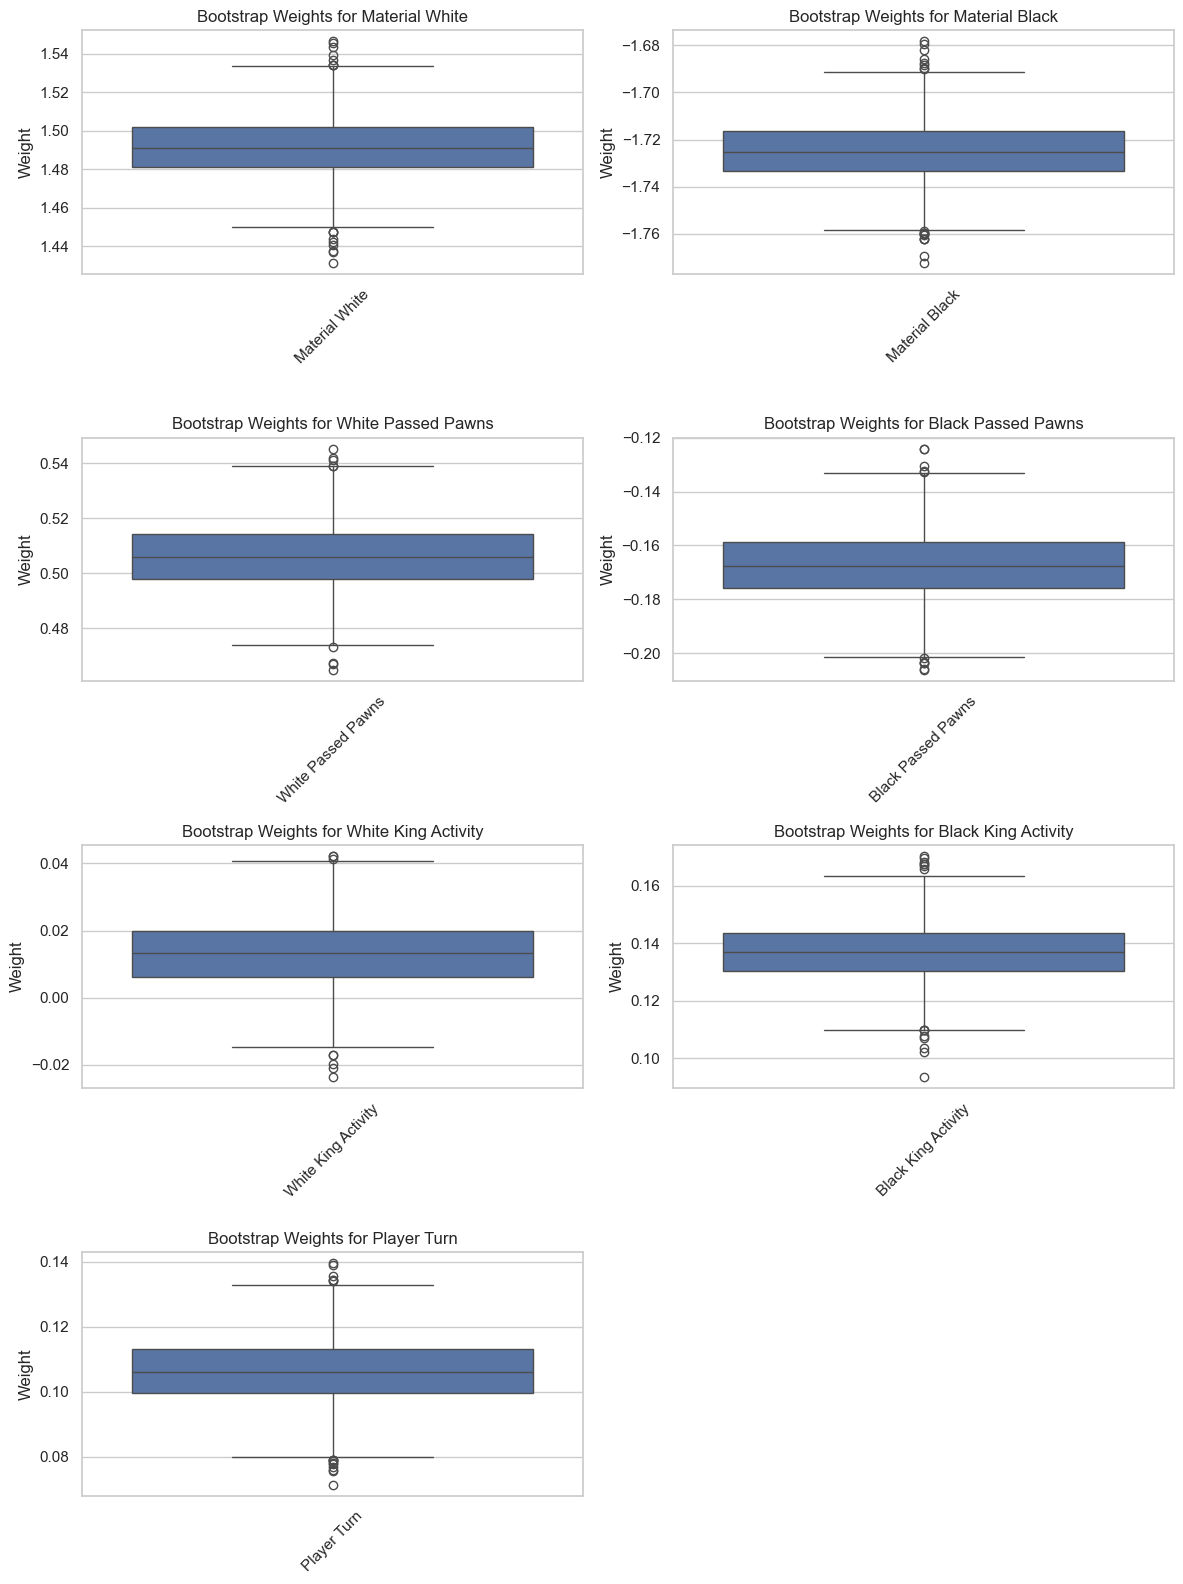

In [47]:
reshaped_w_list = [weights.flatten() for weights in w_list]
features = ['Material White', 'Material Black', 'White Passed Pawns', 
            'Black Passed Pawns', 'White King Activity', 'Black King Activity','Player Turn']
df = pd.DataFrame(reshaped_w_list, columns=features)

means = df.mean()
for feature in features:
    print(f'Mean of {feature}: {means[feature]}')

plt.figure(figsize=(12, 16)) 


for i, feature in enumerate(features):
    plt.subplot(4, 2, i + 1)  
    sns.boxplot(data=df[[feature]])
    plt.xticks(rotation=45)
    plt.ylabel('Weight')
    plt.title(f'Bootstrap Weights for {feature}')


plt.tight_layout()


plt.show()

Mean of Material White: 1.491317759184056
Mean of Material Black: -1.724997128459486
Mean of Player Turn: 0.5061898157578514
Mean of White Passed Pawns: -0.1673641589775836
Mean of Black Passed Pawns: 0.013001687989575596
Mean of White King Activity: 0.13679106826243917
Mean of Black King Activity: 0.10613843273020154


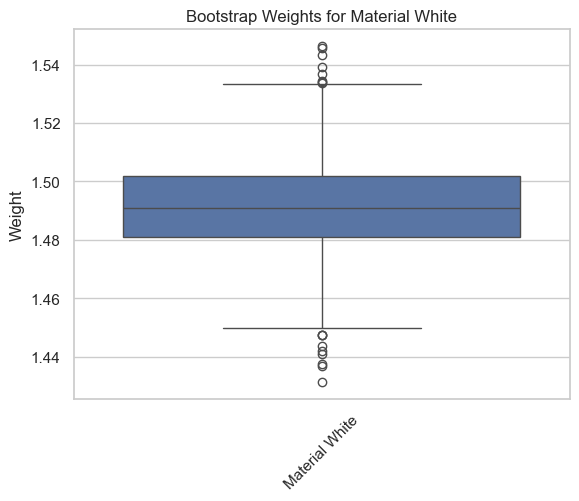

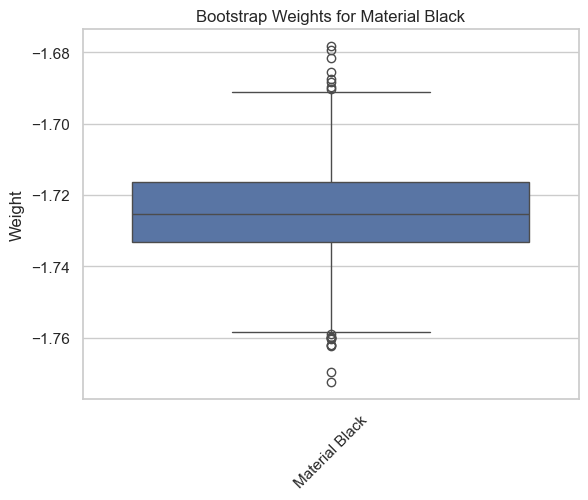

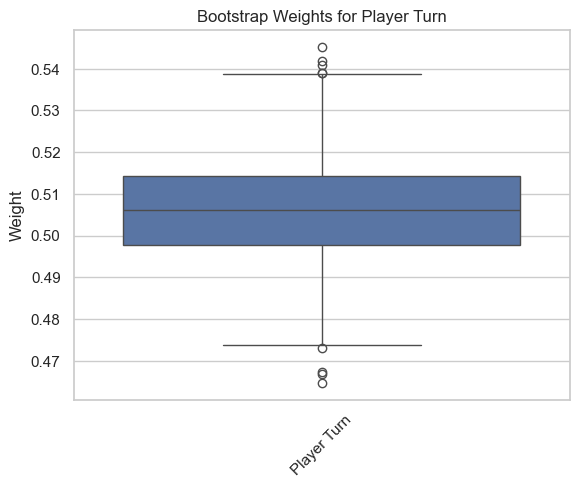

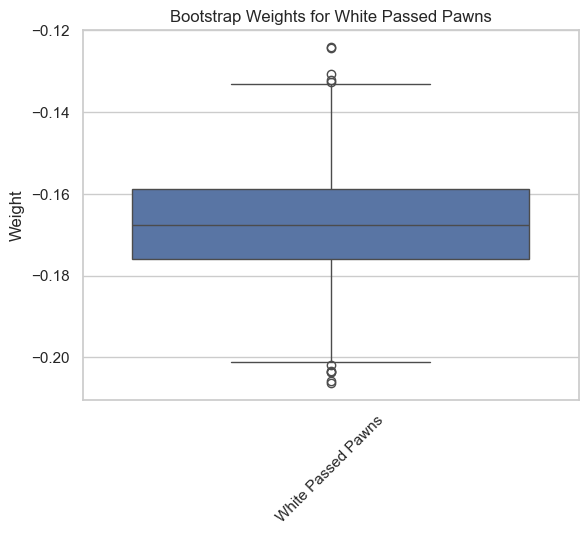

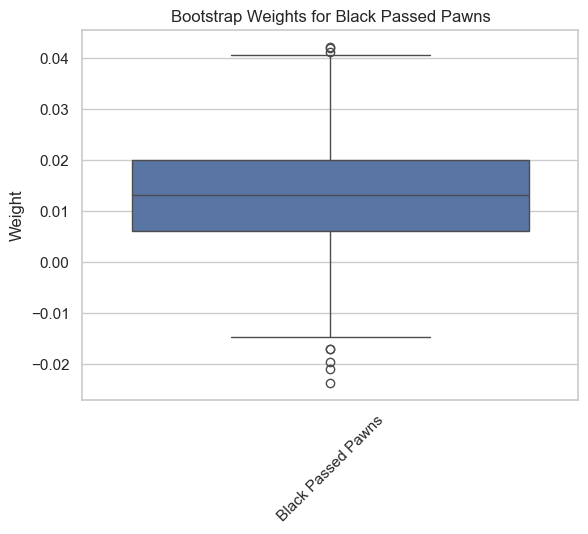

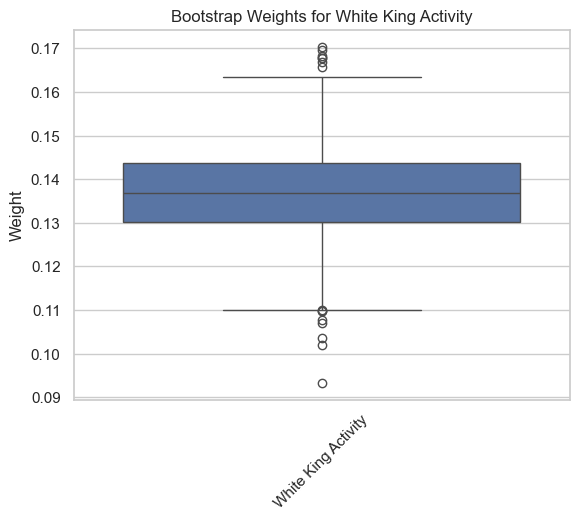

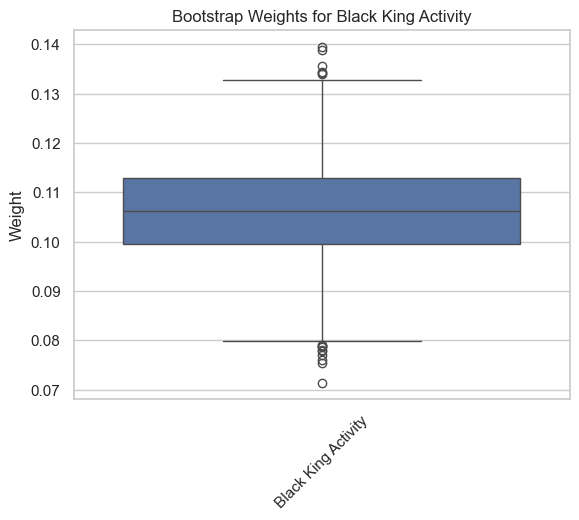

In [48]:
reshaped_w_list = [weights.flatten() for weights in w_list]
features = [ 'Material White','Material Black', 'Player Turn', 'White Passed Pawns', 'Black Passed Pawns', 'White King Activity','Black King Activity']
df = pd.DataFrame(reshaped_w_list, columns=features)

means = df.mean()
for feature in features:
    print(f'Mean of {feature}: {means[feature]}')


for feature in features:
    plt.figure()
    sns.boxplot(data=df[[feature]])
    plt.xticks(rotation=45)
    plt.ylabel('Weight')
    plt.title(f'Bootstrap Weights for {feature}')
    plt.show()

In [49]:
chess_prediction_boot=model_function(chess_data_matrix_lin,means)
scores_boot = calculate_score(chess_prediction_boot, y_val)
print(scores_boot)

79.30594710699422
